**Convolutional Layers**
==

So to do image recognition we need to create a convolutional network!

This takes photo data!


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
color_channels = 1
image_height = 28
image_width  = 28


class CNN:
    def __init__(self, image_height, image_width, channels, num_classes):
        #this input layer holds the image data as is. in the tensor placeholder 
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
        
        #this convolutional layer takes the input data and grabs the kernel_size and breaks
        #that size off and passes it through an activation function that will test similarities to the rest of the image,
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
         
        #the pooling layer removes the precision of the image data
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
         
        #runs a second convolutional layer to take chunk up a second time
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        
        #the pooling layer does the same  shrinkning our# data sets
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
        
        #flatten the data
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        print("Flattened: " + str(flattened_pooling.shape) )
        
        #develops a neural network containing 1024
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print("Dense: " + str(dense_layer.shape))
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        print("Dropout: " + str(dropout.shape))
        outputs = tf.layers.dense(dropout, num_classes)
        print("Outputs: " + str(outputs.shape))
         
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
         
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
         
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)     
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
         
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation = optimizer.minimize(self.loss, global_step=tf.train.get_global_step())


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data_images = input_data.read_data_sets('data/fashion/')
#data_labels = input_data.read_data_sets('data/fashion/train_labels')


Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


[7 2 1 ... 4 5 6]


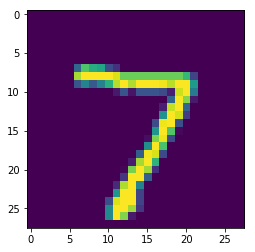

In [19]:
#eval_data = input_data.read_data_sets('data/fashion/eval_images')
#eval_labels = input_data.read_data_sets('data/fashion/eval_labels')
#print(data)

eval_im = data_images.test.images
eval_lab = np.asarray(data_images.test.labels, dtype=np.int32)
print(eval_lab)
e = eval_im[0].reshape(28, 28)
plt.imshow(e)
plt.show()

In [18]:
tf.reset_default_graph()

training_steps = 2000
batch_size = 64

image_height = 28
image_width  = 28

color_channels = 1

train_data = data_images.train.images
train_labels = np.asarray(data_images.train.labels, dtype=np.int32) 

print(train_labels)
#preps the labels for training
print(train_data.shape)
print(train_labels.shape)


cnn = CNN(image_height, image_width, color_channels, 10)

#prep the evaluation data


#eval_labels = np.asarray(data.train.labels, dtype=np.int32)

train_data = train_data.reshape(-1, image_height, image_width, color_channels)


dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size = train_labels.shape[0])
dataset =dataset.batch(batch_size)
dataset = dataset.repeat()
dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        print("Accuracy: " + str(sess.run(cnn.accuracy)))
        #print("Loss: " + sess.run(cnn.loss, feed_dict={cnn.input_layer:batch_inputs}))
    save_path = saver.save(sess, "/tmp/model.ckpt")
    #print("Model saved in path: %s" % save_path)
    #sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:eval_im, cnn.labels:eval_lab})
    #print(sess.run(cnn.accuracy))
    #for image, label in zip(eval_data, eval_labels):
    #    sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
    #print(sess.run(cnn.accuracy))

[7 3 4 ... 5 6 8]
(55000, 784)
(55000,)
(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 64)
(?, 7, 7, 64)
Flattened: (?, 3136)
Dense: (?, 1024)
Dropout: (?, 1024)
Outputs: (?, 10)
Accuracy: 0.0625
Accuracy: 0.1171875
Accuracy: 0.109375
Accuracy: 0.10546875
Accuracy: 0.109375
Accuracy: 0.104166664
Accuracy: 0.09598214
Accuracy: 0.1015625
Accuracy: 0.10243055
Accuracy: 0.1109375
Accuracy: 0.12215909
Accuracy: 0.12760417
Accuracy: 0.12740384
Accuracy: 0.13169643
Accuracy: 0.13229166
Accuracy: 0.13769531
Accuracy: 0.1360294
Accuracy: 0.13541667
Accuracy: 0.13898027
Accuracy: 0.1390625
Accuracy: 0.13988096
Accuracy: 0.13849431
Accuracy: 0.14266305
Accuracy: 0.14257812
Accuracy: 0.144375
Accuracy: 0.1454327
Accuracy: 0.14699075
Accuracy: 0.14955357
Accuracy: 0.15086207
Accuracy: 0.153125
Accuracy: 0.1547379
Accuracy: 0.15478516
Accuracy: 0.15482955
Accuracy: 0.15487133
Accuracy: 0.15892857
Accuracy: 0.16059028
Accuracy: 0.15962838
Accuracy: 0.15995066
Accuracy: 0.15985577
Accuracy

KeyboardInterrupt: 

In [22]:
eval_im = eval_im.reshape(-1, image_height, image_width, color_channels)

print(eval_im.shape)
print(eval_lab.shape)

(10000, 28, 28, 1)
(10000,)


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
My Guess was: 7
[[1.2168059e-06 5.3418973e-03 8.5414993e-03 3.3964089e-01 3.4243043e-04
  3.6075743e-04 8.0172667e-06 9.9624344e+01 6.0292183e-05 2.1356588e-02]]


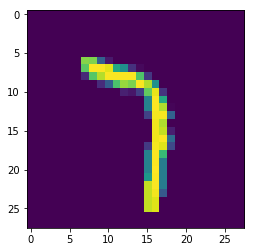

In [27]:
#evaluate_set = tf.data.Dataset.from_tensor_slices(eval_data)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #saver.restore(sess, "/tmp/model.ckpt")
    #print(sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:eval_im, cnn.labels:eval_lab}))
    #print(sess.run(cnn.choice))

    img = eval_im[122]
    img = img.reshape(28, 28)
    plt.imshow(img)
    guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_im[122]]})
    guess_name = str(guess[0])
    print("My Guess was: " + guess_name)
    print(sess.run(cnn.probability, feed_dict={cnn.input_layer:[eval_im[122]]})*100)
    plt.show()

In [ ]:
eval_data = data.train.images[1]
#eval_label = data.train.label(np.asarray(dat))
img = np.array(eval_data, dtype='float')
pix = img.reshape(28, 28)
plt.imshow(pix)

eval_labels = np.asarray(data.train.labels, dtype=np.int32)


